In [1]:

# 1) INSTALLATION & IMPORTS


!pip install -q torch accelerate transformers datasets evaluate scikit-learn matplotlib
!pip install -q huggingface_hub peft bitsandbytes

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # pour de jolis graphiques
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import torch
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification, 
    Trainer, 
    TrainingArguments, 
    DataCollatorWithPadding
)
import evaluate

from peft import LoraConfig, get_peft_model, TaskType

print("=== Librairies importées avec succès ===")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 MB 22.2 MB/s eta 0:00:00:00:0100:01
=== Librairies importées avec succès ===


README.md:   0%|          | 0.00/529 [00:00<?, ?B/s]

(…)-00000-of-00001-dabab110260ac909.parquet:   0%|          | 0.00/6.42M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/76772 [00:00<?, ? examples/s]

                                               input               output  \
0  Teollisuuden Voima Oyj , the Finnish utility k...              neutral   
1  Sanofi poaches AstraZeneca scientist as new re...              neutral   
2  Starbucks says the workers violated safety pol...  moderately negative   
3                      $brcm raises revenue forecast             positive   
4  Google parent Alphabet Inc. reported revenue a...  moderately negative   

                                         instruction  
0  What is the sentiment of this news? Please cho...  
1  What is the sentiment of this news? Please cho...  
2  What is the sentiment of this news? Please cho...  
3  What is the sentiment of this tweet? Please ch...  
4  What is the sentiment of this news? Please cho...  
Taille du DataFrame: (76772, 3)
label
positive    30510
neutral     29215
negative    17047
Name: count, dtype: int64


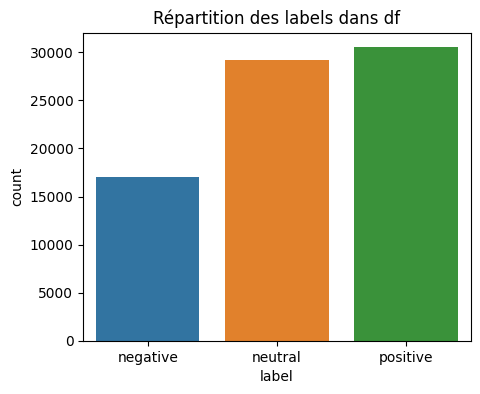

In [2]:

# 2) CHARGEMENT / PREPARATION DU DATASET


# Soit vous utilisez FinGPT/fingpt-sentiment-train, soit un df local. Par exemple:
try:
    # Optionnel : charger depuis Hugging Face
    ds = None
    from datasets import load_dataset
    ds = load_dataset("FinGPT/fingpt-sentiment-train", split="train")
    df = ds.to_pandas()
except:
    # Sinon, on suppose que vous avez déjà "df" en mémoire
    pass

print(df.head(5))
print("Taille du DataFrame:", df.shape)


if "output" in df.columns:
    # Simplification => negative/neutral/positive
    def simplify_label(lbl):
        if "negative" in lbl.lower():
            return "negative"
        elif "positive" in lbl.lower():
            return "positive"
        else:
            return "neutral"
    df["label"] = df["output"].apply(simplify_label)
    df = df[["input","label"]].reset_index(drop=True)

# Distribution
print(df["label"].value_counts())

# Graph: distribution
plt.figure(figsize=(5,4))
sns.countplot(data=df, x="label", order=["negative","neutral","positive"])
plt.title("Répartition des labels dans df")
plt.show()


In [3]:

# 3) SPLIT (TRAIN/VAL/TEST)


train_df, temp_df = train_test_split(
    df, 
    test_size=0.30, 
    random_state=42,
    stratify=df["label"]
)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.66,
    random_state=42,
    stratify=temp_df["label"]
)

print("Train size:", len(train_df))
print("Val size:", len(val_df))
print("Test size:", len(test_df))


Train size: 53740
Val size: 7830
Test size: 15202


LogReg best params: {'C': 10, 'solver': 'lbfgs'}
LogReg best CV f1: 0.8696865028037825
[LogReg] Val: Acc=0.891, F1=0.886
RF best params: {'max_depth': None, 'n_estimators': 200}
RF best CV f1: 0.86376699574876
[RandomForest] Val: Acc=0.898, F1=0.890

=== Baseline sur Test ===
LogReg : Acc=0.890, F1=0.884
RF     : Acc=0.898, F1=0.888


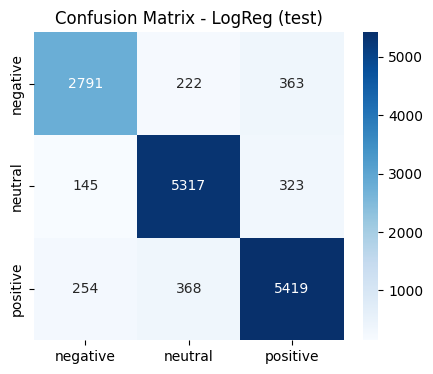

In [4]:

# 4) BASELINES SCIKIT-LEARN (LogReg, RF)


# A) TF-IDF
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_train = vectorizer.fit_transform(train_df["input"])
y_train = train_df["label"]

X_val   = vectorizer.transform(val_df["input"])
y_val   = val_df["label"]

X_test  = vectorizer.transform(test_df["input"])
y_test  = test_df["label"]

# B) LogisticRegression + GridSearch
params_lr = {
    "C": [0.01, 0.1, 1, 10],
    "solver":["lbfgs","liblinear"]
}
lr_grid = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    params_lr,
    cv=3,
    scoring="f1_macro",
    n_jobs=-1
)
lr_grid.fit(X_train, y_train)
best_lr = lr_grid.best_estimator_
print("LogReg best params:", lr_grid.best_params_)
print("LogReg best CV f1:", lr_grid.best_score_)

# Éval sur val
val_pred_lr = best_lr.predict(X_val)
acc_val_lr  = accuracy_score(y_val, val_pred_lr)
f1_val_lr   = f1_score(y_val, val_pred_lr, average='macro')
print(f"[LogReg] Val: Acc={acc_val_lr:.3f}, F1={f1_val_lr:.3f}")

# C) RandomForest + GridSearch
params_rf = {
    "n_estimators":[50,100,200],
    "max_depth":[None, 10, 20]
}
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    params_rf,
    cv=3,
    scoring="f1_macro",
    n_jobs=-1
)
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_
print("RF best params:", rf_grid.best_params_)
print("RF best CV f1:", rf_grid.best_score_)

val_pred_rf = best_rf.predict(X_val)
acc_val_rf  = accuracy_score(y_val, val_pred_rf)
f1_val_rf   = f1_score(y_val, val_pred_rf, average='macro')
print(f"[RandomForest] Val: Acc={acc_val_rf:.3f}, F1={f1_val_rf:.3f}")

# D) Test final
test_pred_lr = best_lr.predict(X_test)
acc_test_lr  = accuracy_score(y_test, test_pred_lr)
f1_test_lr   = f1_score(y_test, test_pred_lr, average='macro')

test_pred_rf = best_rf.predict(X_test)
acc_test_rf  = accuracy_score(y_test, test_pred_rf)
f1_test_rf   = f1_score(y_test, test_pred_rf, average='macro')

print("\n=== Baseline sur Test ===")
print(f"LogReg : Acc={acc_test_lr:.3f}, F1={f1_test_lr:.3f}")
print(f"RF     : Acc={acc_test_rf:.3f}, F1={f1_test_rf:.3f}")

# Graph: confusion matrix (ex: LogReg)
cm_lr = confusion_matrix(y_test, test_pred_lr, labels=["negative","neutral","positive"])
plt.figure(figsize=(5,4))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues",
            xticklabels=["negative","neutral","positive"],
            yticklabels=["negative","neutral","positive"])
plt.title("Confusion Matrix - LogReg (test)")
plt.show()


Map:   0%|          | 0/53740 [00:00<?, ? examples/s]

Map:   0%|          | 0/7830 [00:00<?, ? examples/s]

Map:   0%|          | 0/15202 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Map:   0%|          | 0/53740 [00:00<?, ? examples/s]

Map:   0%|          | 0/7830 [00:00<?, ? examples/s]

Map:   0%|          | 0/15202 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-5-2f9e35e4d026>:82: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.479500,0.431221,0.833206,0.831878,0.832194,0.833332
2,0.402700,0.381945,0.857088,0.856085,0.856634,0.857739
3,0.386000,0.358775,0.870754,0.869105,0.868284,0.870771


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



=== FinBERT-lora sur Test ===
{'eval_loss': 0.36801207065582275, 'eval_accuracy': 0.8627812129982897, 'eval_f1': 0.860682557533892, 'eval_precision': 0.8609984681155147, 'eval_recall': 0.8617969230277357, 'eval_runtime': 90.1572, 'eval_samples_per_second': 168.617, 'eval_steps_per_second': 10.548, 'epoch': 3.0}
FinBERT-lora (test) -> Acc=0.863, F1=0.861


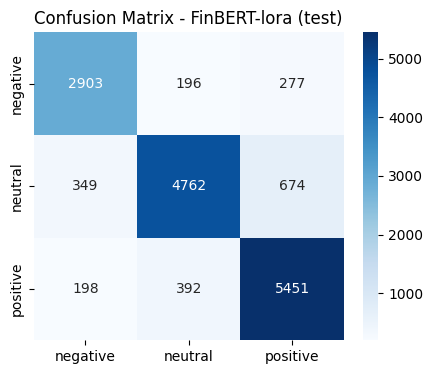

In [5]:

# 5) APPROCHE AVANCEE (FINBERT, LoRA)


# On peut faire la même chose pour DistilBERT, RoBERTa, etc.
model_name = "ProsusAI/finbert"

label_list = ["negative","neutral","positive"]
label2id = {lbl:i for i,lbl in enumerate(label_list)}
id2label = {i:lbl for i,lbl in enumerate(label_list)}

def encode_label_hf(example):
    example["labels"] = label2id[example["label"]]
    return example

train_ds = Dataset.from_pandas(train_df.reset_index(drop=True)).map(encode_label_hf)
val_ds   = Dataset.from_pandas(val_df.reset_index(drop=True)).map(encode_label_hf)
test_ds  = Dataset.from_pandas(test_df.reset_index(drop=True)).map(encode_label_hf)

tokenizer_ = AutoTokenizer.from_pretrained(model_name)
base_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
)

if tokenizer_.pad_token is None:
    tokenizer_.add_special_tokens({"pad_token": "[PAD]"})
    base_model.resize_token_embeddings(len(tokenizer_))

def tokenize_map(ex):
    return tokenizer_(
        ex["input"],
        padding="max_length",
        truncation=True,
        max_length=128  # 128 suffisant la plupart du temps -> plus rapide
    )

train_tok = train_ds.map(tokenize_map, batched=True)
val_tok   = val_ds.map(tokenize_map,   batched=True)
test_tok  = test_ds.map(tokenize_map,  batched=True)

train_tok = train_tok.remove_columns(["input","label"])
val_tok   = val_tok.remove_columns(["input","label"])
test_tok  = test_tok.remove_columns(["input","label"])

collator_ = DataCollatorWithPadding(tokenizer=tokenizer_)

# LoRA config
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["query","value"]
)
model_lora = get_peft_model(base_model, peft_config)

def compute_metrics_lora(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc  = accuracy_score(labels, preds)
    f1   = f1_score(labels, preds, average='macro')
    prec = precision_score(labels, preds, average='macro')
    rec  = recall_score(labels, preds, average='macro')
    return {"accuracy": acc, "f1": f1, "precision": prec, "recall": rec}

training_args = TrainingArguments(
    output_dir="./finbert_best",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_steps=100,
    fp16=True,  # accelerate le training
    report_to="none"  # pas de wandb
)

trainer = Trainer(
    model=model_lora,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    tokenizer=tokenizer_,
    data_collator=collator_,
    compute_metrics=compute_metrics_lora
)

trainer.train()
trainer.save_model("./finbert_lora_final")
tokenizer_.save_pretrained("./finbert_lora_final")

# EVAL
test_results = trainer.evaluate(test_tok)
print("\n=== FinBERT-lora sur Test ===")
print(test_results)

preds = []
for i in range(len(test_tok)):
    txt_ids = test_tok[i]["input_ids"]
    atn_mask = test_tok[i]["attention_mask"]
    # On reconstruit un batch de 1
    inp_tens = {
        "input_ids": torch.tensor([txt_ids], dtype=torch.long, device=model_lora.device),
        "attention_mask": torch.tensor([atn_mask], dtype=torch.long, device=model_lora.device)
    }
    with torch.no_grad():
        out_ = model_lora(**inp_tens)
    pred_id = out_.logits.argmax(dim=1).item()
    preds.append(pred_id)

true_labels = test_tok["labels"]
acc_finbert  = accuracy_score(true_labels, preds)
f1_finbert   = f1_score(true_labels, preds, average='macro')
print(f"FinBERT-lora (test) -> Acc={acc_finbert:.3f}, F1={f1_finbert:.3f}")

# Matrice de confusion
cm_fin = confusion_matrix(true_labels, preds, labels=[0,1,2])
plt.figure(figsize=(5,4))
sns.heatmap(cm_fin, annot=True, cmap="Blues", fmt="d", 
            xticklabels=["negative","neutral","positive"],
            yticklabels=["negative","neutral","positive"])
plt.title("Confusion Matrix - FinBERT-lora (test)")
plt.show()


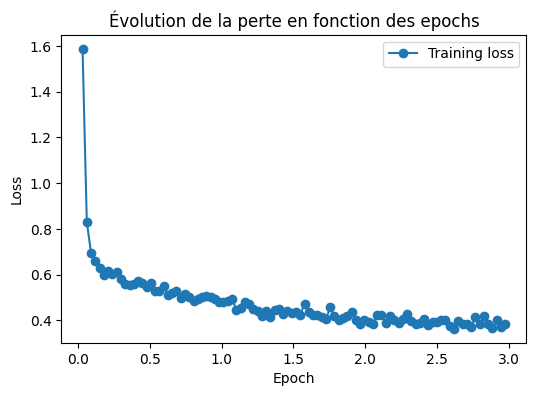

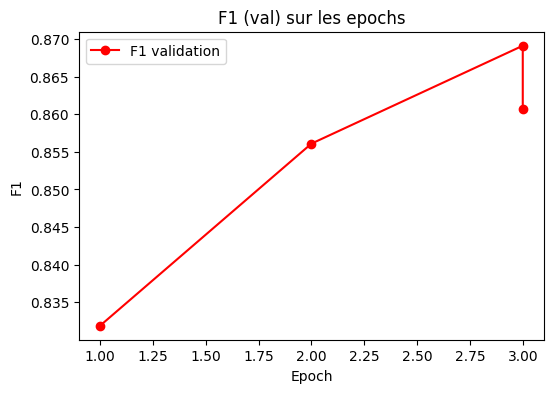

In [6]:

# 6) GRAPHIQUES D'EVOLUTION (si logs)


# Pour tracer la courbe de loss/accuracy par epoch,
# 2 possibilités : 
# - Soit on parse le TrainingArguments output (eventually in logs)
# - Soit on fait trainer.train() + trainer.state.log_history

logs = trainer.state.log_history
# logs est une liste de dicos: [{'loss':..., 'learning_rate':..., 'epoch':..., 'step':...}, ...]

losses = []
eval_f1 = []
epochs = []

for entry in logs:
    if "loss" in entry and "epoch" in entry:
        losses.append(entry["loss"])
        epochs.append(entry["epoch"])
    if "eval_f1" in entry:
        eval_f1.append((entry["epoch"], entry["eval_f1"]))

plt.figure(figsize=(6,4))
plt.plot(epochs, losses, marker="o", label="Training loss")
plt.title("Évolution de la perte en fonction des epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# On peut tracer la courbe f1 sur epoch
if eval_f1:
    ep_f1, val_f1 = zip(*eval_f1)
    plt.figure(figsize=(6,4))
    plt.plot(ep_f1, val_f1, marker="o", c="red", label="F1 validation")
    plt.title("F1 (val) sur les epochs")
    plt.xlabel("Epoch")
    plt.ylabel("F1")
    plt.legend()
    plt.show()


In [7]:
df

,input,label
0,"Teollisuuden Voima Oyj , the Finnish utility k...",neutral
1,Sanofi poaches AstraZeneca scientist as new re...,neutral
2,Starbucks says the workers violated safety pol...,negative
3,$brcm raises revenue forecast,positive
4,Google parent Alphabet Inc. reported revenue a...,negative
...,...,...
76767,"BP, Statoil, to Withdraw Staff From Algeria Fo...",negative
76768,NEW YORK — A fire broke out late Wednesday at ...,negative
76769,Operating profit margin increased from 11.2 % ...,positive
76770,$vxx adding to position here !,positive
